<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/bro.png" width="100px"></div>

# Converting Bro logs to Parquet files
Apache Parquet is a columnar storage format focused on performance. Parquet data is often used within the Hadoop ecosystem and we will specifically be using it for loading data into both Pandas and Spark.

<div style="float: right; margin: 30px -100px 0px 0px"><img src="images/parquet.png" width="300px"></div>

### Software
- Bro Analysis Tools (BAT): https://github.com/Kitware/bat
- Pandas: https://github.com/pandas-dev/pandas
- Parquet: https://parquet.apache.org/

<div style="float: right; margin: 30px 0px 0px 0px"><img src="images/spark.png" width="200px"></div>

### Data
- Sec Repo: http://www.secrepo.com (there's no Bro headers on these)
- Kitware: https://data.kitware.com/#collection/58d564478d777f0aef5d893a (with headers)

<div style="float: left; margin: 80px 20px 50px 20px"><img src="images/bleeding.jpg" width="250px"></div>
### Bleeding Edge Warning:
You know you're on the bleeding edge when you link PRs that are still open/in-progess. There are **two open issues** with saving Parquet Files right now.

- Timestamps in Spark: https://issues.apache.org/jira/browse/ARROW-1499
- TimeDelta Support: https://issues.apache.org/jira/browse/ARROW-835

For Spark timestamps, the BAT Parquet writer used below will output INT96 timestamps for now (we'll change over later when ARROW-1499 is complete). 

For the TimeDelta support we'll just have to wait until that gets pushed into the main branch and released.

In [1]:
# Third Party Imports
import pyspark
from pyspark.sql import SparkSession
import pyarrow

# Local imports
import bat
from bat.log_to_parquet import log_to_parquet

# Good to print out versions of stuff
print('BAT: {:s}'.format(bat.__version__))
print('PySpark: {:s}'.format(pyspark.__version__))
print('PyArrow: {:s}'.format(pyarrow.__version__))

BAT: 0.2.7
PySpark: 2.2.0
PyArrow: 0.6.0


## Bro IDS log to Parquet File
Here we're loading in a Bro HTTP log with ~2 million rows to demonstrate the functionality and do some simple spark processing on the data.
- log_to_parquet is iterative so it can handle large files
- 'row_group_size' defaults to 1 Million rows but can be set manually

In [2]:
# Create a Pandas dataframe from a Bro log
# You can download these Bro logs from https://data.kitware.com/#collection/58d564478d777f0aef5d893a
filename = '/Users/briford/data/bro/sec_repo/http.log'
log_to_parquet(filename, 'http.parquet')

Successfully monitoring /Users/briford/data/bro/sec_repo/http.log...
Writing 0 rows...
Writing 1000000 rows...
Writing 2000000 rows...
Writing 2048441 rows...
Parquet File Complete


<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/compressed.jpeg" width="300px"></div>

# Parquet files are compressed
Here we see the first benefit of Parquet which stores data with compressed columnar format. There are several compression options available (including uncompressed).

## Original http.log = 1.3 GB 
## http.parquet = 106 MB

In [3]:
# Spin up a local Spark Session
spark = SparkSession.builder.appName('my_awesome').getOrCreate()

In [4]:
# Have Spark read in the Parquet File (very fast)
%time spark_df = spark.read.parquet("http.parquet")

CPU times: user 2.19 ms, sys: 1.38 ms, total: 3.57 ms
Wall time: 2.88 s


<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/fast.jpg" width="350px"></div>

# Parquet files are fast
We see from the above timer output that the Parquet file only takes a few seconds to read into Spark.

<div style="float: left; margin: 20px 20px 20px 20px"><img src="images/eyeball.jpeg" width="150px"></div>
# Lets look at our data
We should always inspect out data when it comes in. Look at both the data values and the data types to make sure you're getting exactly what you should be.

In [5]:
# Get information about the Spark DataFrame
num_rows = spark_df.count()
print("Number of Spark DataFrame rows: {:d}".format(num_rows))
columns = spark_df.columns
print("Columns: {:s}".format(','.join(columns)))

Number of Spark DataFrame rows: 2048442
Columns: filename,host,id.orig_h,id.orig_p,id.resp_h,id.resp_p,info_code,info_msg,method,orig_fuids,orig_mime_types,password,proxied,referrer,request_body_len,resp_fuids,resp_mime_types,response_body_len,status_code,status_msg,tags,trans_depth,uid,uri,user_agent,username,ts


In [39]:
spark_df.select(['`id.orig_h`', 'host', 'uri', 'status_code', 'user_agent']).show(5)

+--------------+---------------+--------------+-----------+--------------------+
|     id.orig_h|           host|           uri|status_code|          user_agent|
+--------------+---------------+--------------+-----------+--------------------+
|192.168.202.79|192.168.229.251|/DEASLog02.nsf|        404|Mozilla/5.0 (comp...|
|192.168.202.79|192.168.229.251|/DEASLog03.nsf|        404|Mozilla/5.0 (comp...|
|192.168.202.79|192.168.229.251|/DEASLog04.nsf|        404|Mozilla/5.0 (comp...|
|192.168.202.79|192.168.229.251|/DEASLog05.nsf|        404|Mozilla/5.0 (comp...|
|192.168.202.79|192.168.229.251|  /DEASLog.nsf|        404|Mozilla/5.0 (comp...|
+--------------+---------------+--------------+-----------+--------------------+
only showing top 5 rows



<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/deep_dive.jpeg" width="350px"></div>

# Data looks good, lets take a deeper dive
We should always inspect out data when it comes in. Look at both the data values and the data types to make sure you're getting exactly what you should be.

Spark has a powerful SQL engine as well as a Machine Learning library. Here we're just going to run some of the SQL commands to do some investigation of our data.
<div style="float: left; margin: 20px 0px 0px 0px"><img src="images/spark_sql.jpg" width="150px"></div>
<div style="float: right; margin: 0px 50px 0px 0px"><img src="images/mllib.png" width="150px"></div>

In [27]:
spark_df.groupBy('`id.orig_h`', 'host', 'uri', 'status_code').count()\
        .sort('count', ascending=False).show()

+---------------+---------------+--------------------+-----------+-----+
|      id.orig_h|           host|                 uri|status_code|count|
+---------------+---------------+--------------------+-----------+-----+
|192.168.202.102| 192.168.23.202|           /main.php|        200|31590|
|192.168.202.102| 192.168.26.202|           /main.php|        200|31305|
|192.168.202.102| 192.168.24.202|           /main.php|        200|27694|
|192.168.202.102| 192.168.28.202|           /main.php|        200|17544|
|192.168.202.102| 192.168.22.202|           /main.php|        200| 8477|
| 192.168.202.65|  192.168.201.2|/resources/getCur...|        200| 5261|
| 192.168.202.76|192.168.229.156|/admin/config.php...|        200| 2949|
|192.168.202.110|192.168.229.251|                   /|        200| 2130|
|192.168.202.125| 192.168.25.203|/phpmyadmin/index...|        200| 2121|
|192.168.202.110| 192.168.27.203|                   /|        200| 2081|
|192.168.202.102|192.168.229.101|              /log

<div style="float: right; margin: 0px 50px 0px 0px"><img src="images/anxious.jpg" width="150px"></div>

# The 192.168.202.102 Host is Making us Nervous
- We'll create a dataframe just for that machine with the SQL where clause
- Then we group up that machines activity
- Looks like the machine is performing Recon

In [36]:
from pyspark.sql.functions import col
interesting_df = spark_df.where(col('`id.orig_h`') == '192.168.202.102')
print("Number of Rows: {:d}".format(interesting_df.count()))
interesting_df.groupBy('host', 'uri', 'statu# Show histogram of the Spark DF query lengths

Number of Rows: 212234
+---------------+---------------+--------------------+-----------+-----+
|      id.orig_h|           host|                 uri|status_code|count|
+---------------+---------------+--------------------+-----------+-----+
|192.168.202.102| 192.168.23.202|           /main.php|        200|31590|
|192.168.202.102| 192.168.26.202|           /main.php|        200|31305|
|192.168.202.102| 192.168.24.202|           /main.php|        200|27694|
|192.168.202.102| 192.168.28.202|           /main.php|        200|17544|
|192.168.202.102| 192.168.22.202|           /main.php|        200| 8477|
|192.168.202.102|192.168.229.101|              /login|        200| 1658|
|192.168.202.102| 192.168.23.202|        /help.php?q=|        200|  748|
|192.168.202.102| 192.168.23.202|       /add_note.php|        200|  668|
|192.168.202.102|              -|                   /|        302|  345|
|192.168.202.102|192.168.229.101|                   /|        200|  336|
|192.168.202.102|           

In [43]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
from bat.utils import plot_utils
plot_utils.plot_defaults()

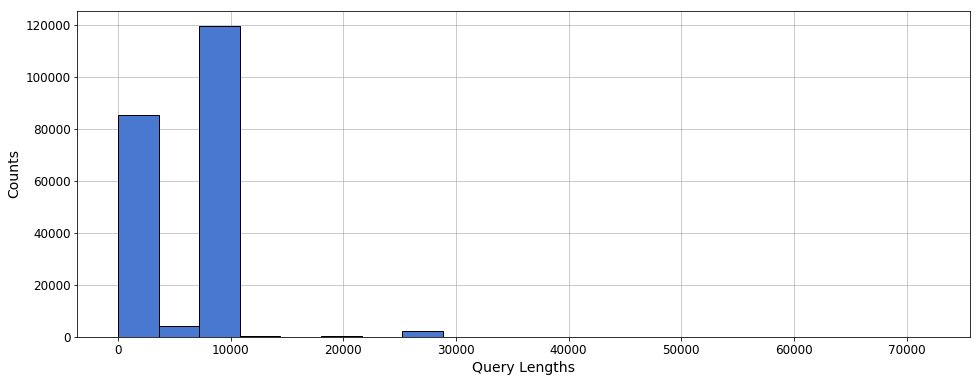

In [46]:
# Show histogram of the Spark DF query lengths
bins, counts = interesting_df.select('response_body_len').rdd.flatMap(lambda x: x).histogram(20)

# This is a bit awkward but I believe this is the correct way to do it
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.grid(True)
plt.xlabel('Query Lengths')
plt.ylabel('Counts')

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/pandas_real.png" width="400px"></div>

# Pandas are Nice
Since we now are looking a one particular machine we can convert to Pandas DataFrame and use the resample/plotting methods.
<div style="float: left; margin: 20px 20px 20px 20px"><img src="images/pandas.png" width="200px"></div>

In [53]:
http_df = interesting_df.select('ts', 'host', 'status_code').toPandas().set_index('ts', drop=True)
http_df.head()

,host,status_code
ts,,
2012-03-16 01:02:04.740,-,400
2012-03-16 01:02:57.040,192.168.22.203,200
2012-03-16 01:02:57.140,192.168.22.203,404
2012-03-16 01:03:04.460,-,400
2012-03-16 01:03:04.460,-,400


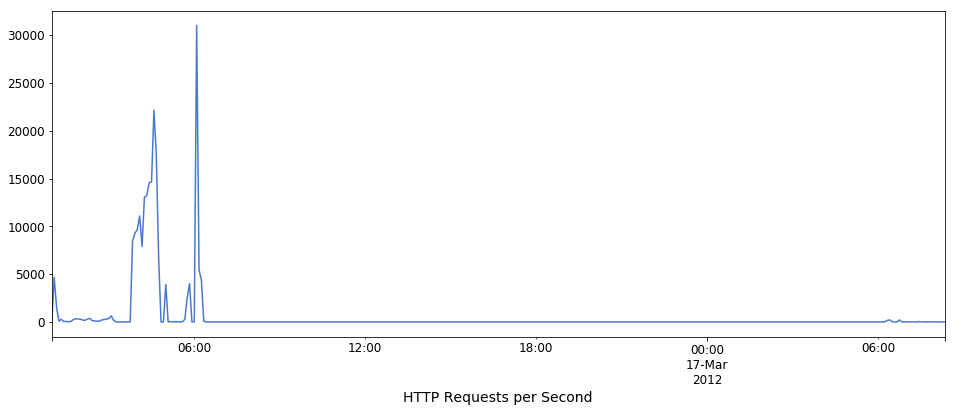

In [55]:
http_df['host'].resample('5Min').count().plot()
plt.xlabel('HTTP Requests per Second')

<div style="float: right; margin: 50px 0px 0px 0px"><img src="https://www.kitware.com/img/small_logo_over.png"></div>
## Wrap Up
Well that's it for this notebook, we went from a Bro log to a high performance Parquet file and then did some digging with SQL and plotting.

If you liked this notebook please visit the [BAT](https://github.com/Kitware/bat) project for more notebooks and examples.